In [1]:
from foodbornenyc.models import models as m, documents as d, businesses as b, locations as l
db = m.getDBSession()

In [2]:
%%time
reviews = db.query(d.YelpReview).limit(100000).all()

CPU times: user 3.14 s, sys: 488 ms, total: 3.62 s
Wall time: 3.67 s


In [7]:
%%time
count = db.execute("select count(yelp_id) from dbo.yelp_reviews")

CPU times: user 654 µs, sys: 919 µs, total: 1.57 ms
Wall time: 428 ms


In [11]:
print count.first()

(2479899,)


In [15]:
import lda
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
import csv
with open('reviews_foodborne.csv') as f:
    reader = csv.reader(f)
    reader.next()
    pos_data = [ row[0] for row in reader if float(row[1]) == 1.0]
with open('reviews_foodborne.csv') as f:
    reader = csv.reader(f)
    reader.next()
    neg_data = [ row[0] for row in reader if float(row[1]) == 0.0]
with open('reviews_foodborne.csv') as f:
    reader = csv.reader(f)
    reader.next()
    all_data = [ row[0] for row in reader]  


In [17]:
print len(all_data)

5394


In [40]:
def run_lda(data, n_topics=10, n_iter=1000, random_state=0):
    print "Running LDA with %i topics and %i iterations..." % (n_topics, n_iter)
    cv = CountVectorizer('content', strip_accents='unicode', analyzer='word', stop_words='english', max_df=.9, min_df=2, ngram_range=(1,1))
    X = cv.fit_transform(data)
    vocab = [x[0] for x in sorted(cv.vocabulary_.items(), key=lambda x:x[1])]
    print "(N,V): ",X.shape
    model = lda.LDA(n_topics=n_topics, n_iter=1000, random_state=0)
    model.fit(X)
    results = {'n_topics':n_topics,
               'n_iter':n_iter,
               'vocab':vocab,
               'model':model,
               'X':X
              }
    return results

def print_topics(model, vocab, top_k=10):
    topic_words = model.topic_word_
    for i, topic_dist in enumerate(topic_words):
        topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(top_k+1):-1]
        print('\tTopic {}: {}'.format(i+1, ', '.join(topic_words)))
        print
    print

In [74]:
# experiment
sample_sizes = [2500, 7500, 17500, 37500, 77500]
n_topics = 20
results = []
for s in sample_sizes:
    sample = [ r.text for r in np.random.choice(reviews, size=s, replace=False)]
    data = pos_data[:2500] + sample
    labels = np.concatenate((np.ones(2500), np.zeros(len(sample)))).reshape((len(data), 1))
    results.append(run_lda(data, n_topics=n_topics))

Running LDA with 20 topics and 1000 iterations...
(N,V): 

 (5000, 9053)
Running LDA with 20 topics and 1000 iterations...
(N,V): 

 (10000, 13434)
Running LDA with 20 topics and 1000 iterations...
(N,V): 

 (20000, 19187)
Running LDA with 20 topics and 1000 iterations...
(N,V): 

 (40000, 26999)
Running LDA with 20 topics and 1000 iterations...
(N,V): 

 (80000, 37370)


In [79]:
#1/64
sample = [ r.text for r in np.random.choice(reviews, size=77500, replace=False)]
data = pos_data[:1250] + sample
labels = np.concatenate((np.ones(1250), np.zeros(len(sample)))).reshape((len(data), 1))
results.append(run_lda(data, n_topics=n_topics))

Running LDA with 20 topics and 1000 iterations...
(N,V): 

 (78750, 37264)


In [80]:
for r in results:
    print r['X'].shape
    print_topics(r['model'], r['vocab'])

(5000, 9053)
	Topic 1: food, place, got, service, sick, poisoning, bad, eat, terrible, want

	Topic 2: order, said, manager, told, called, asked, restaurant, did, service, food

	Topic 3: good, like, just, really, place, don, pretty, think, didn, ve

	Topic 4: new, ve, place, years, know, just, time, york, like, city

	Topic 5: lobster, dish, restaurant, like, good, ordered, dinner, steak, dishes, sauce

	Topic 6: food, great, service, good, place, nice, wine, amazing, menu, restaurant

	Topic 7: pizza, cheese, sauce, good, slice, pasta, italian, pie, try, slices

	Topic 8: sushi, roll, fish, fresh, rolls, tuna, lunch, good, place, spicy

	Topic 9: food, poisoning, got, sick, day, night, hours, stomach, ate, ordered

	Topic 10: coffee, tea, chocolate, cream, ice, cake, like, delicious, dessert, good

	Topic 11: table, came, minutes, wait, service, took, night, time, food, waiter

	Topic 12: place, just, like, don, sure, people, make, line, know, pretty

	Topic 13: sick, chicken, ordere

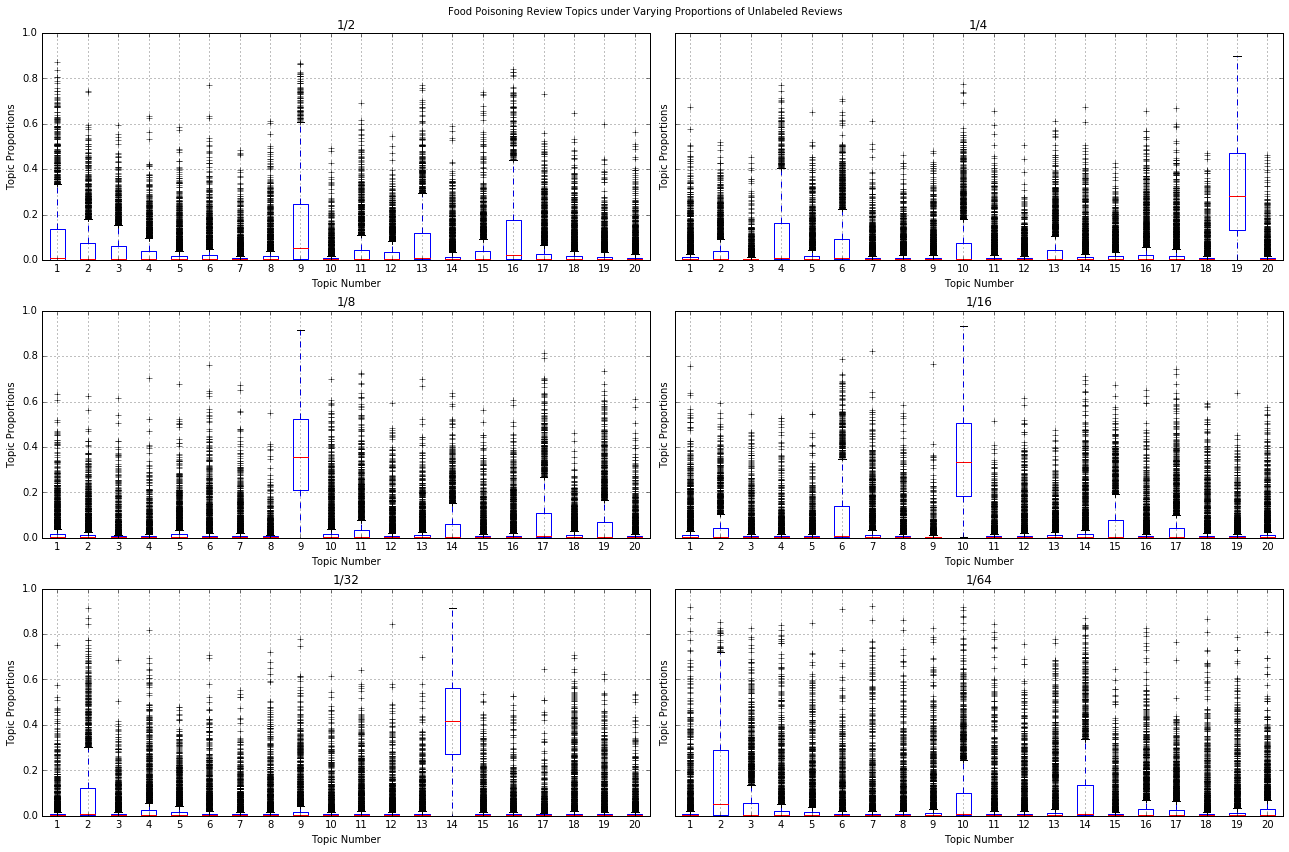

In [87]:
fig, axarr = plt.subplots(3,2, figsize=(18,12), sharey=True)
# axarr[-1, -1].axis('off')
titles = ["1/2", "1/4", "1/8", "1/16", "1/32", "1/64"]
for k, r in enumerate(results):
    model = r['model']
    thetas = model.doc_topic_
    i,j = divmod(k, 2)
    a = axarr[i,j]
    a.boxplot(thetas[:2500])
    a.grid()
    a.set_title(titles[k])
    a.set_xlabel("Topic Number")
    a.set_ylabel("Topic Proportions")

fig.suptitle("Food Poisoning Review Topics under Varying Proportions of Unlabeled Reviews")
plt.tight_layout()
plt.subplots_adjust(top=.95)
plt.savefig('lda_boxplot_drown_6.png')

(5000, 9053)
	Topic 1: food, place, got, service, sick, poisoning, bad, eat, terrible, want

	Topic 2: order, said, manager, told, called, asked, restaurant, did, service, food

	Topic 3: good, like, just, really, place, don, pretty, think, didn, ve

	Topic 4: new, ve, place, years, know, just, time, york, like, city

	Topic 5: lobster, dish, restaurant, like, good, ordered, dinner, steak, dishes, sauce

	Topic 6: food, great, service, good, place, nice, wine, amazing, menu, restaurant

	Topic 7: pizza, cheese, sauce, good, slice, pasta, italian, pie, try, slices

	Topic 8: sushi, roll, fish, fresh, rolls, tuna, lunch, good, place, spicy

	Topic 9: food, poisoning, got, sick, day, night, hours, stomach, ate, ordered

	Topic 10: coffee, tea, chocolate, cream, ice, cake, like, delicious, dessert, good

	Topic 11: table, came, minutes, wait, service, took, night, time, food, waiter

	Topic 12: place, just, like, don, sure, people, make, line, know, pretty

	Topic 13: sick, chicken, ordere

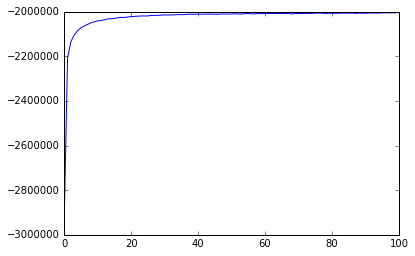

In [94]:
result = results[0]
print result['X'].shape
print_topics(result['model'], result['vocab'])
print result['model'].loglikelihoods_
plt.plot(result['model'].loglikelihoods_, '-')

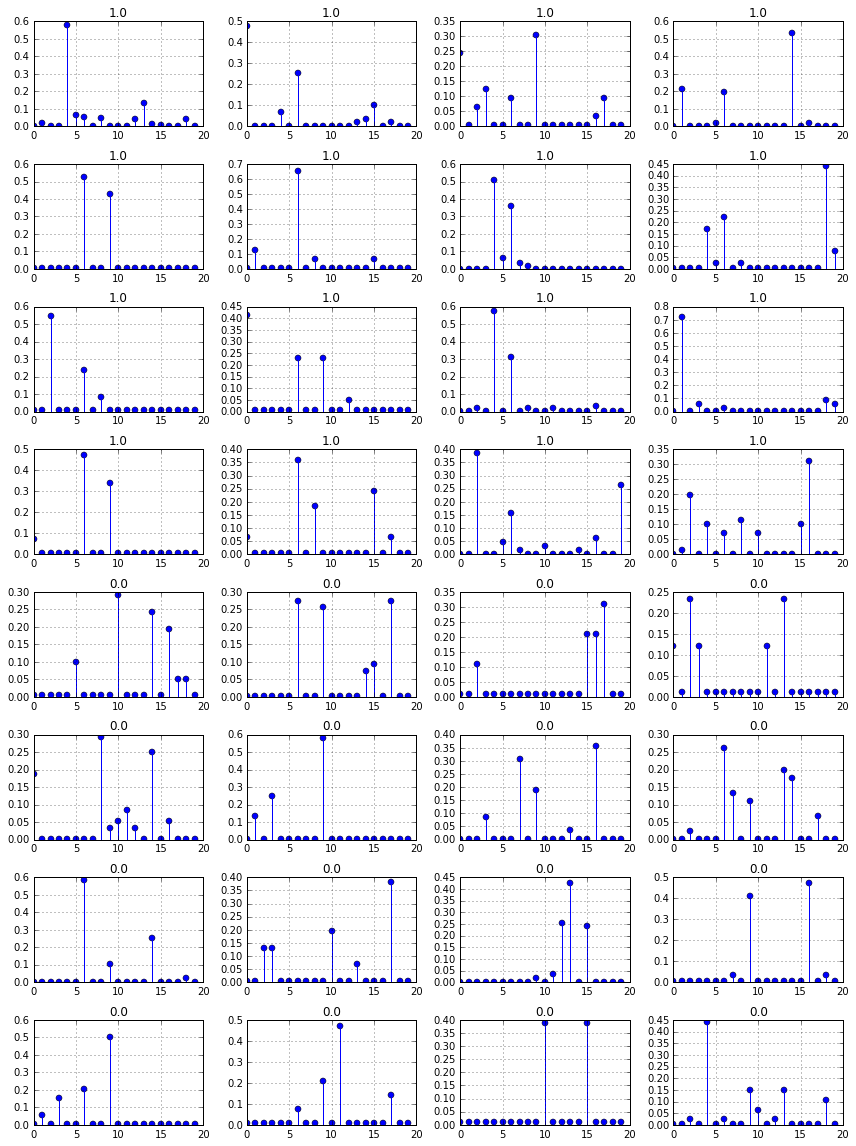

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
model = result['model']
thetas = model.doc_topic_
dists = np.hstack((thetas, labels))
#print results[0:10,:]
res_example = np.vstack((dists[0:16,:], dists[-16:,:]))
#print res_example.shape
fig, axarr = plt.subplots(8,4, figsize=(12,16))
for k,r in enumerate(res_example):
    #print i,j, ' :: ', r
    i,j = divmod(k,4)
    y = r[-1]
    x = r[:-1]
    axarr[i,j].stem(x)
    axarr[i,j].set_title(str(y))
    axarr[i,j].grid()
plt.tight_layout()

In [20]:
# experiment
n_topics = 20
sample = [ r.text for r in np.random.choice(reviews, size=7500, replace=False)]
data = pos_data[:2500] + sample
labels = np.concatenate((np.ones(2500), np.zeros(len(sample)))).reshape((len(data), 1))
results = run_lda(data, n_topics=n_topics)

Running LDA with 20 topics and 1000 iterations...
(N,V): 

 (10000, 13495)


In [89]:
#print results['X'].shape
# print_topics(results['model'], results['vocab'])
print results['model'].loglikelihoods_

TypeError: list indices must be integers, not str

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
model = results['model']
thetas = model.doc_topic_

dists = np.hstack((thetas, labels))
pos = thetas[np.random.randint(2500, size=100), :]
neg = thetas[np.random.randint(2500,10000, size=100), :]

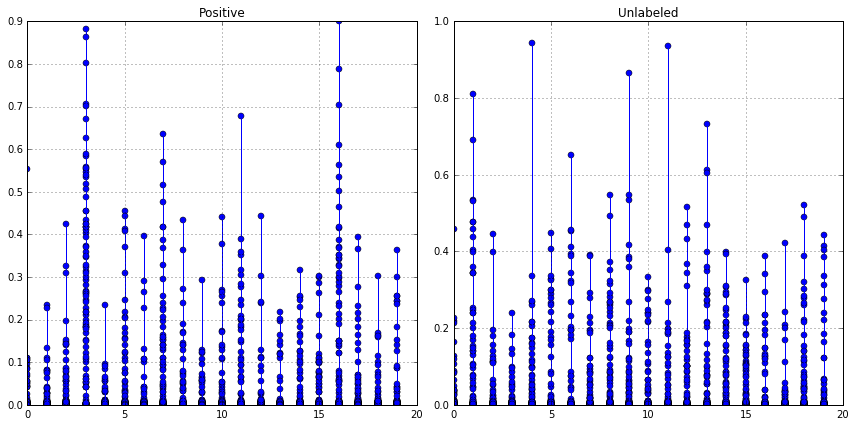

In [33]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6))
for p in pos:
    ax0.stem(thetas[:2500], alpha=.01)
ax0.grid()
ax0.set_title("Positive")
for n in neg:
    ax1.stem(n, alpha=.01)
ax1.grid()
ax1.set_title("Unlabeled")
plt.tight_layout()

# #print results[0:10,:]
# res_example = np.vstack((dists[0:16,:], dists[-16:,:]))
# #print res_example.shape
# fig, axarr = plt.subplots(8,4, figsize=(12,16))
# for k,r in enumerate(res_example):
#     #print i,j, ' :: ', r
#     i,j = divmod(k,4)
#     y = r[-1]
#     x = r[:-1]
#     axarr[i,j].stem(x)
#     axarr[i,j].set_title(str(y))
#     axarr[i,j].grid()
# plt.tight_layout()

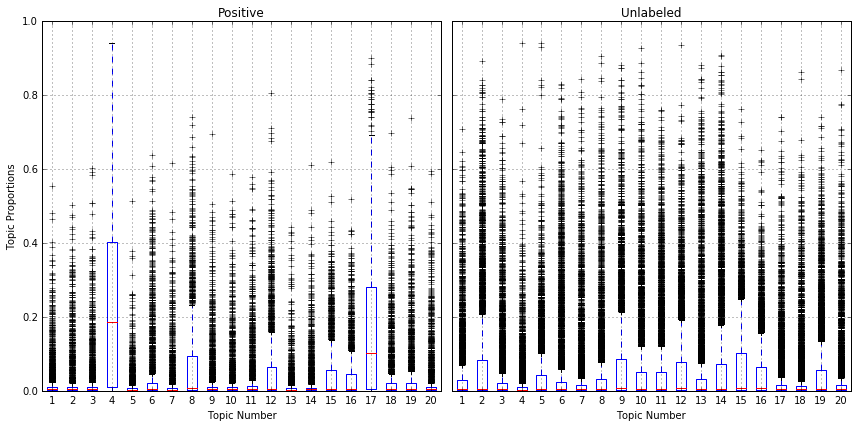

In [63]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6), sharey=True)
ax0.boxplot(thetas[:2500])
ax0.grid()
ax0.set_title("Positive")
ax0.set_xlabel("Topic Number")
ax0.set_ylabel("Topic Proportions")
ax1.boxplot(thetas[2500:])#np.random.randint(2500,10000,size=2500),:])
ax1.grid()
ax1.set_title("Unlabeled")
ax1.set_xlabel("Topic Number")

plt.tight_layout()
plt.savefig('lda_boxplot_2500_7500.pdf')

### So it looks like 4 and 17 are the food poisoning topics here.
Let's plot all the unlabeled reviews that have topic 4 or 17 in high proportions (>.5)

In [51]:
sample = np.array(sample)
likely = sample[np.where(thetas[2500:,3] > .5)]
others = sample[np.where(thetas[2500:,16] >.5)]
print len(likely), len(others)

8 31


In [57]:
al = np.hstack((likely, others))
for i,r in enumerate(al):
    print i, ":: ", r
    print

0 ::  Yikes...it had been years since I ate at Baluchis. Disappointing. Hope they return to focusing on food/cooking again.

1 ::  I used to go to Mika with my wife. We are so disappointed that it is closed. I hope they will reopen soon.

2 ::  Very very disappointed. I went yesterday to buy food, And my son and me, we begin sick all night from yesterday (5pm). We're still in emergency room (intoxicated). I'm very very disappointed,  they supposed to have fresh food in the rest.  GRRRRRRRR Grrrrrr

3 ::  I have only been back one time since I wrote the first review. I would have ordered from here many more times but the prices keep me away.

4 ::  Great market - the kind people here brightened my days when i was helping my daughter recover from ACL surgery.  They went above & beyond every time I stopped in.  I even got a tour one day to be sure I knew where everything was.  Highly recommend!

5 ::  The first time I dined here in September, I totally enjoyed both the food's taste and pr